In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.4)
from fastai.vision import * #Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import fastai; fastai.__version__

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/XRayDataSet/'
#THIS PATH SHOULD HAVE TWO FOLDERS: COVID and NON-COVID (w/e)

image_dataset = torchvision.datasets.ImageFolder(root=path)
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.2)


print(len(train_dataset))
print(len(test_dataset))

class_num_covid = image_dataset.class_to_idx['Covid-19']
class_num_not_covid = image_dataset.class_to_idx['ANo_findings']
print('Covid-19 Class: ', class_num_covid)
print('Not-Covid-19 Class: ', class_num_not_covid)

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

client_dataset = []
for i in range(len(train_dataset)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([1,0]) if train_dataset[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader = torch.utils.data.DataLoader(dataset=client_dataset, batch_size=32)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
504
126
Covid-19 Class:  1
Not-Covid-19 Class:  0


In [3]:
import torch
import urllib
import zipfile
import torchvision
from torchvision import transforms
from torchsummary import summary
import torchvision.models
import torchvision.models.convnext
import torchvision.models as models

model1 = models.convnext_tiny(pretrained=True)
model2 = models.convnext_tiny(pretrained=True)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


  0%|          | 0.00/109M [00:00<?, ?B/s]

In [4]:
print(model1)

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [5]:
num_classes = 2
model1.classifier[2] = nn.Linear(768, num_classes)
model2.classifier[2] = nn.Linear(768, num_classes)

In [6]:
print(model1)

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [7]:
ct = 0
for child in model1.children():
  ct += 1
  if ct==1:
    print("this is child 1")
    for param in child.parameters():
        param.requires_grad = False
  print("Next Child")
  print(child)
print(ct)

this is child 1
Next Child
Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (1): Sequential(
    (0): CNBlock(
      (block): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=384, bias=True)
        (4): GELU()
        (5): Linear(in_features=384, out_features=96, bias=True)
        (6): Permute()
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): CNBlock(
      (block): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=384, bias=True)
        (4): GELU()
        (5

In [8]:
ct = 0
for child in model2.children():
  ct += 1
  if ct==1:
    print("this is child 1")
    for param in child.parameters():
        param.requires_grad = False
  print("Next Child")
  print(child)
print(ct)

this is child 1
Next Child
Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (1): Sequential(
    (0): CNBlock(
      (block): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=384, bias=True)
        (4): GELU()
        (5): Linear(in_features=384, out_features=96, bias=True)
        (6): Permute()
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
    (1): CNBlock(
      (block): Sequential(
        (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=96, out_features=384, bias=True)
        (4): GELU()
        (5

In [9]:
ct = 0
ct2=0
for child in model1.children():
  ct += 1
  print("Next")
  for param in child.parameters():
      ct2=ct2+1
      print(param.requires_grad)
  #print(child)
print(ct)
print(ct2)

Next
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

In [10]:
ct = 0
for child in model2.children():
  ct += 1
  print("Next")
  for param in child.parameters():
      print(param.requires_grad)
  #print(child)
print(ct)

Next
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

In [11]:
ct=0
for param in model1.parameters():
  
  if param.grad is not None:
    ct=ct+1

print(ct)

ct=0
for layer, param in model2.named_parameters():
  
  if param.grad is not None:
    ct=ct+1

print(ct)

ct=0
for layer, param in model2.named_parameters():
  
  if param.requires_grad==True:
    ct=ct+1

print(ct)

0
0
4


In [12]:
import copy

In [20]:
def c_mat(y_true, y_pred):
    _t = [int(1 if i[0] < i[1] else 0) for i in y_true]
    # print('y_pred: ' + str(y_pred))
    # _p = [int(1 if i[0] > 0 else 0) for i in y_pred]
    _p = [int(1 if i[0] < i[1] else 0) for i in y_pred]
    # print('target: ' + str(_t))
    # print('predicted: ' + str(_p))
    tn, fp, fn, tp = confusion_matrix(_t, _p, labels=[0, 1]).ravel()
    # print('tn: ' + str(tn), ' fp: ' + str(fp), ' fn: ' + str(fn), ' tp: ' + str(tp))
    # print('fp: ' + str(fp))
    # print('fn: ' + str(fn))
    # print('tp: ' + str(tp))
    return tn, fp, fn, tp

class Adam_Optimizer():
    
    def __init__(self, num_items,num_factors, beta_1=0.9, beta_2=0.99, gemma=0.003, epsilon=1e-8):
        """Initialize
        Args:
        num_items:  Total number of items in the data
        num_factors: Number of factors
        beta_1: hyper-parameter
        beta_2: hyper-parameter
        gemma: hyper-parameter
        epsilon: hyper-parameter
        """
        self.num_items = num_items
        self.num_factors = num_factors
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.gemma = gemma
        self.epsilon = epsilon
        
        self.m = np.zeros((self.num_items, self.num_factors))
        self.v = np.zeros((self.num_items, self.num_factors))
        self.t = 0
    
    # This method is used to calculate the gradient using Adam optimizer
    def optimize_gradients(self, gradients):
        
        self.t += 1
        
        self.m = (self.beta_1 * self.m) + (1.0 - self.beta_1) * gradients              #Equation 13
        #self.m = (self.beta_1 * self.m) + (1.0 - self.beta_1)              #Equation 13
        #print(self.m.shape)
        #print(gradients.shape)
        self.v = (self.beta_2 * self.v) + (1.0 - self.beta_2) * np.square(gradients)   #Equation 14
        
        # Calculates the bias-corrected estimates
        m_hat = self.m/(1.0 - (self.beta_1**self.t))  #Equation 15
        v_hat = self.v/(1.0 - (self.beta_2**self.t))  #Equation 16
        
        new_gradients = self.gemma * (m_hat) / (np.sqrt(v_hat) + self.epsilon) #Equation 17
        
        return new_gradients

class FL_Client():
    def __init__(self, input , target):
        self.input = input
        self.target = target
        #self.ae = AE()

        #self.ae = model1
        self.ae = copy.deepcopy(model1)
        
        # self.criterion = nn.MSELoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.ae.parameters(), lr = 2e-5)
    
    def set_input_and_target(self, input , target):
        self.input = input
        self.target = target

    def train_model(self):
      self.optimizer.zero_grad()
      #print(self.input.shape)
      output = self.ae(self.input)
      self.target.requires_grad = False
      #print("Output: ", output)
      tn, fp, fn, tp = c_mat(self.target, output)
      loss = self.criterion(output, self.target)
      loss.backward()
      return loss.item(), tn, fp, fn, tp
    
    def get_gradients(self):
      with torch.no_grad():
        gradients_arr = []
        for param in self.ae.parameters():
          
          #if param.grad is not None:
          if param.requires_grad==True:
            grad = param.grad.numpy()
            gradients_arr.append(grad)
          
          #gradients_arr.append(grad)
          #gradients_arr.append(param.grad.numpy())

        return gradients_arr

    def set_weights(self, weights):
      #print(len(weights))
      with torch.no_grad():
        i = 0
        for name, param in self.ae.named_parameters():
          param.data = weights[i]
          i += 1

class FL_Server():
    """
    # Receive and load gradients from FL_Client
    # Update weights using gradients
    # Send weights to FL_Server
    """
    
    def __init__(self):
        #self.ae = AE()
        #self.ae = model2
        self.ae = copy.deepcopy(model2)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.ae.parameters(), lr = 2e-5)
        self.dct = {} #layer:layer.shape
        self.adam_optimizer = {} #layer:optim_for_that_layer
        self.new_grad = []

        for layer, param in self.ae.named_parameters():
          #if param.grad is not None:
          if param.requires_grad==True:
            self.dct[layer] = param.shape
            #param.data = torch.zeros(param.shape)
            shp = param.data.reshape(param.shape[0],-1).shape
            # print(param.shape," -> ",shp)
            self.adam_optimizer[layer] = Adam_Optimizer(shp[0], shp[1])
        
    def train_test_model_and_get_loss(self, input, target):
      with torch.no_grad():
        output = self.ae(input)
        tn, fp, fn, tp = c_mat(target, output)
        loss = self.criterion(output, target)
        return loss.item(), tn, fp, fn, tp

    def update_grad(self, grad_arr):
      #grad_arr = gradients of multiple clients
      new_grad = grad_arr[0]
      for grad in grad_arr:
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          new_grad[i] = self.adam_optimizer[layer].optimize_gradients(grad[i].reshape(param.shape[0],-1))
      
      with torch.no_grad():
        self.optimizer.zero_grad()
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          # param.grad = new_grad[i].reshape(self.dct[layer])
          param.grad = torch.Tensor(new_grad[i].reshape(self.dct[layer]))

    def aggregate_grads(self, grad):
      if len(self.new_grad)==0:
        self.new_grad = [np.zeros_like(x) for x in grad]
      for i in range(len(grad)):
        self.new_grad[i]+=grad[i]

    def update_grad_v2(self):

      i = -1
      for layer, param in self.ae.named_parameters():
        if param.requires_grad==True:
          i += 1
          self.new_grad[i] = self.adam_optimizer[layer].optimize_gradients(self.new_grad[i].reshape(param.shape[0],-1))
      
      with torch.no_grad():
        self.optimizer.zero_grad()
        i = -1
        for layer, param in self.ae.named_parameters():
          if param.requires_grad==True:
            i += 1
            # param.grad = self.new_grad[i].reshape(self.dct[layer])
            param.grad = torch.Tensor(self.new_grad[i].reshape(self.dct[layer]))

      self.new_grad=[]


    def update_grad_v3(self, grad_arr):
      new_grad = [np.zeros_like(x) for x in grad_arr[0]]
      for gradient in grad_arr:
        for i in range(len(gradient)):
          new_grad[i] += gradient[i]

      for i in range(len(new_grad)):
        new_grad[i] = new_grad[i] / len(grad_arr)

      self.optimizer.zero_grad()
      with torch.no_grad():
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          param.grad = torch.Tensor(new_grad[i])

    def train_model(self):
      ct=0
      with torch.no_grad():
        for layer, param in self.ae.named_parameters():
          #if param.grad is not None:
          if param.requires_grad==True: 
            ct=ct+1
            param.data -= param.grad
      print("parameters trained: " + str(ct))

    def train_model_v2(self):
      self.optimizer.step()

    def get_weights(self):
      with torch.no_grad():
        weights = []
        for name, param in self.ae.named_parameters():
          weights.append(param.data)
        return weights



In [14]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=40)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([1,0]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [30]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 50
threshold = int(len(train_dataset1) / 10)
train_loss_arr1 = []
train_acc_arr1 = []
train_prec_arr1 = []
train_recall_arr1 = []
train_f1_arr1 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  clients_arr = []
  for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))

  length=len(clients_arr)

  for j in range(length):
    fl_client=clients_arr[0]
    del clients_arr[0]
    if epoch != 1:
      fl_client.set_weights(copy.deepcopy(global_weights))
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    fl_server.aggregate_grads(fl_client.get_gradients())
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2()
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr1.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr1.append(accuracy)
  train_prec_arr1.append(precision)
  train_recall_arr1.append(recall)
  train_f1_arr1.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  50
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.6843559741973877 . L-AC:  0.625 . L-P:  0.6923076923076923 . L-R:  0.8181818181818182 . L-F1:  0.75
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.6800687909126282 . L-AC:  1.25 . L-P:  1.465034965034965 . L-R:  1.5265151515151516 . L-F1:  2.2451433099869837
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.6813357472419739 . L-AC:  1.8125 . L-P:  2.2377622377622375 . L-R:  2.1803613053613056 . L-F1:  4.453832200730877
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.7023285031318665 . L-AC:  2.375 . L-P:  2.9746043430253954 . L-R:  2.7890569575352187 . L-F1:  7.332676222333082
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.6679790019989014 . L-AC:  2.96875 . L-P:  3.8246043430253955 . L-R:  3.4186865871648484 . L-F1:  10.94294776733367

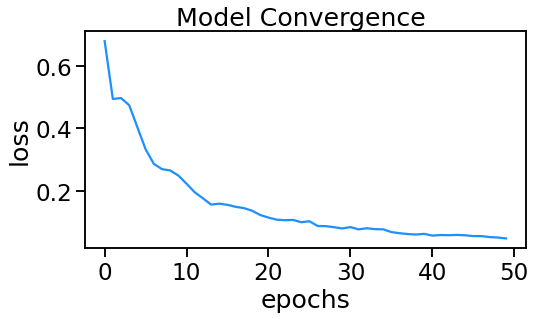

In [31]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr1)),train_loss_arr1,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

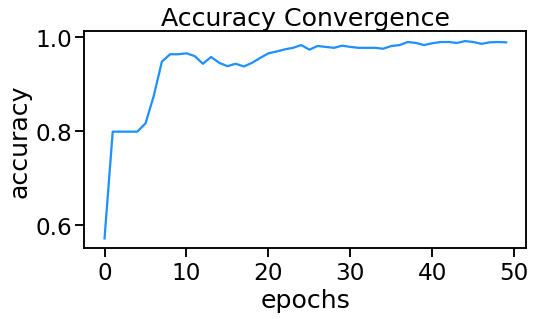

In [32]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr1)),train_acc_arr1,color='dodgerblue')
plt.title('Accuracy Convergence')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.tight_layout()

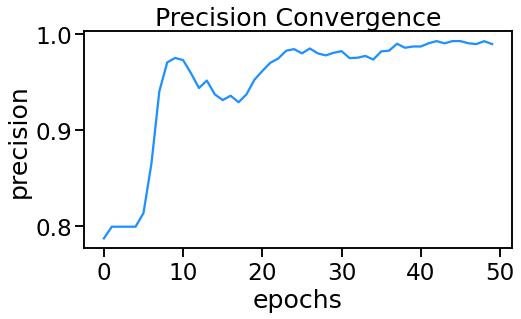

In [33]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr1)),train_prec_arr1,color='dodgerblue')
plt.title('Precision Convergence')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.tight_layout()

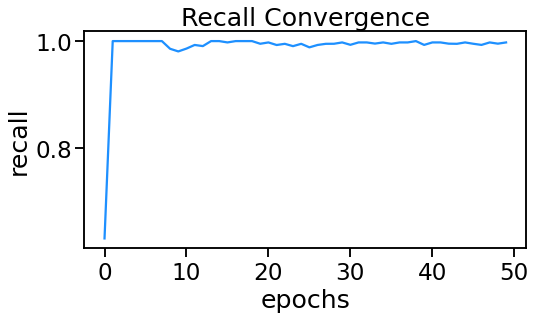

In [34]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr1)),train_recall_arr1,color='dodgerblue')
plt.title('Recall Convergence')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.tight_layout()

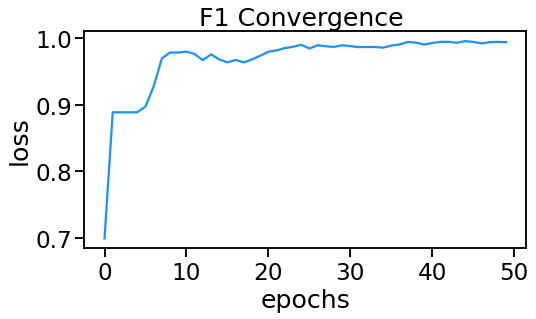

In [35]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr1)),train_f1_arr1,color='dodgerblue')
plt.title('F1 Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

In [37]:
test_client_dataset1 = []
for i in range(len(test_dataset1)):
    test_client_dataset1.append((train_transforms(test_dataset1[i][0]), torch.Tensor([1,0]) if test_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))
test_client_loader1 = torch.utils.data.DataLoader(dataset=test_client_dataset1, batch_size=32)
len(test_client_loader1)

4

In [38]:
test_loss_arr1 = []
test_acc_arr1 = []
test_prec_arr1 = []
test_recall_arr1 = []
test_f1_arr1 = []

for batch_idx, (features, labels) in enumerate(test_client_loader1):
  local_loss, _tn, _fp, _fn, _tp = fl_server.train_test_model_and_get_loss(features,labels)
  _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
  _precision = _tp/(_tp+_fp)
  _recall = _tp/(_tp+_fn)
  _f1 = 2/((1/_recall) + (1/_precision))
  test_loss_arr1.append(local_loss)
  test_acc_arr1.append(_accuracy)
  test_prec_arr1.append(_precision)
  test_recall_arr1.append(_recall)
  test_f1_arr1.append(_f1)
  print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.1357261836528778 . Accuracy:  0.90625 . Precision:  0.8928571428571429 . Recall:  1.0 . F1-Score:  0.9433962264150942
Batch  1 . Loss:  0.07397640496492386 . Accuracy:  0.96875 . Precision:  0.9615384615384616 . Recall:  1.0 . F1-Score:  0.9803921568627451
Batch  2 . Loss:  0.14786697924137115 . Accuracy:  0.9375 . Precision:  0.9310344827586207 . Recall:  1.0 . F1-Score:  0.9642857142857141
Batch  3 . Loss:  0.034608159214258194 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0


# 1st **end**

# **45**

In [39]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=45)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([1,0]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [41]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 50
threshold = int(len(train_dataset1) / 10)
train_loss_arr2 = []
train_acc_arr2 = []
train_prec_arr2 = []
train_recall_arr2 = []
train_f1_arr2 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  clients_arr = []
  for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))

  length=len(clients_arr)

  for j in range(length):
    fl_client=clients_arr[0]
    del clients_arr[0]
    if epoch != 1:
      fl_client.set_weights(copy.deepcopy(global_weights))
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    fl_server.aggregate_grads(fl_client.get_gradients())
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2()
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr2.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr2.append(accuracy)
  train_prec_arr2.append(precision)
  train_recall_arr2.append(recall)
  train_f1_arr2.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  50
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.7189185619354248 . L-AC:  0.46875 . L-P:  0.6190476190476191 . L-R:  0.5909090909090909 . L-F1:  0.6046511627906977
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.705317497253418 . L-AC:  0.9375 . L-P:  1.3032581453634084 . L-R:  1.1325757575757576 . L-F1:  1.816588133961595
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.7147951126098633 . L-AC:  1.40625 . L-P:  2.0401002506265664 . L-R:  1.6710372960372961 . L-F1:  3.6538057329248206
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.6702514290809631 . L-AC:  2.125 . L-P:  2.8901002506265665 . L-R:  2.4101677308199045 . L-F1:  6.282211084230742
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.6678029894828796 . L-AC:  2.71875 . L-P:  3.7789891395154553 . L-R:  3.002760323412497 . L-F1: 

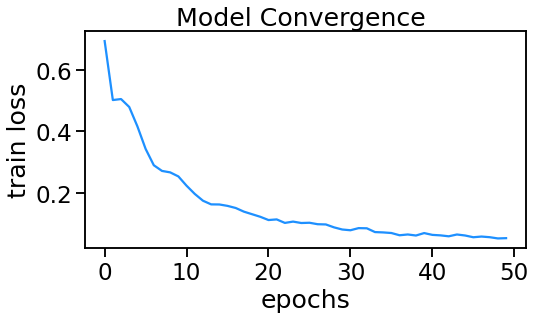

In [42]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr2)),train_loss_arr2,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

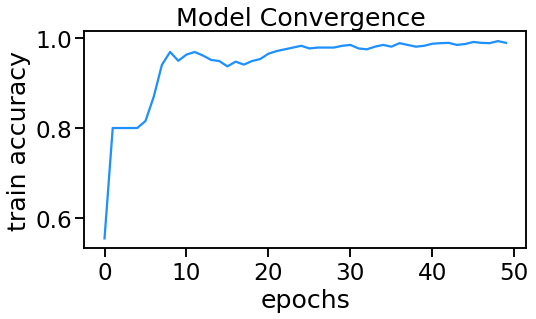

In [43]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr2)),train_acc_arr2,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

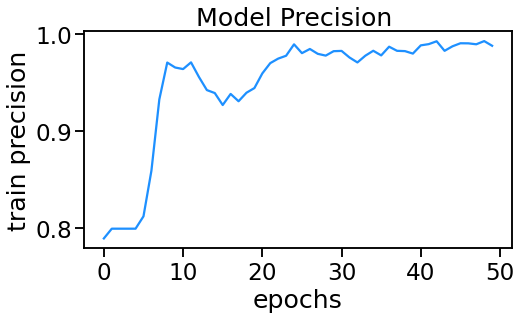

In [44]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr2)),train_prec_arr2,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

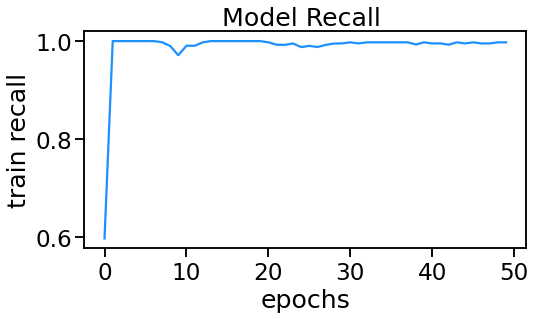

In [45]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr2)),train_recall_arr2,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

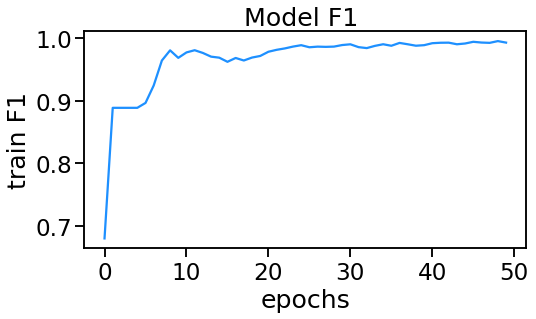

In [46]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr2)),train_f1_arr2,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [47]:
test_client_dataset1 = []
for i in range(len(test_dataset1)):
    test_client_dataset1.append((train_transforms(test_dataset1[i][0]), torch.Tensor([1,0]) if test_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))
test_client_loader1 = torch.utils.data.DataLoader(dataset=test_client_dataset1, batch_size=32)
len(test_client_loader1)

4

In [48]:
test_loss_arr2 = []
test_acc_arr2 = []
test_prec_arr2 = []
test_recall_arr2 = []
test_f1_arr2 = []

for batch_idx, (features, labels) in enumerate(test_client_loader1):
  local_loss, _tn, _fp, _fn, _tp = fl_server.train_test_model_and_get_loss(features,labels)
  _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
  _precision = _tp/(_tp+_fp)
  _recall = _tp/(_tp+_fn)
  _f1 = 2/((1/_recall) + (1/_precision))
  test_loss_arr2.append(local_loss)
  test_acc_arr2.append(_accuracy)
  test_prec_arr2.append(_precision)
  test_recall_arr2.append(_recall)
  test_f1_arr2.append(_f1)
  print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.10387538373470306 . Accuracy:  0.9375 . Precision:  0.9259259259259259 . Recall:  1.0 . F1-Score:  0.9615384615384615
Batch  1 . Loss:  0.07110273838043213 . Accuracy:  0.96875 . Precision:  0.9615384615384616 . Recall:  1.0 . F1-Score:  0.9803921568627451
Batch  2 . Loss:  0.11563099920749664 . Accuracy:  0.9375 . Precision:  0.9310344827586207 . Recall:  1.0 . F1-Score:  0.9642857142857141
Batch  3 . Loss:  0.022787733003497124 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0


# **50**

In [49]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=50)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([1,0]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [51]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 50
threshold = int(len(train_dataset1) / 10)
train_loss_arr3 = []
train_acc_arr3 = []
train_prec_arr3 = []
train_recall_arr3 = []
train_f1_arr3 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  clients_arr = []
  for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))

  length=len(clients_arr)

  for j in range(length):
    fl_client=clients_arr[0]
    del clients_arr[0]
    if epoch != 1:
      fl_client.set_weights(copy.deepcopy(global_weights))
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    fl_server.aggregate_grads(fl_client.get_gradients())
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2()
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr3.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr3.append(accuracy)
  train_prec_arr3.append(precision)
  train_recall_arr3.append(recall)
  train_f1_arr3.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  50
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.7089468240737915 . L-AC:  0.5 . L-P:  0.65 . L-R:  0.5909090909090909 . L-F1:  0.6190476190476191
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.7500563263893127 . L-AC:  0.75 . L-P:  1.1115384615384616 . L-R:  0.8517786561264822 . L-F1:  1.5835222100175992
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.7308295965194702 . L-AC:  1.1875 . L-P:  1.7479020979020978 . L-R:  1.4351119894598154 . L-F1:  3.15966054195961
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.6923112869262695 . L-AC:  1.75 . L-P:  2.597902097902098 . L-R:  2.0422548466026726 . L-F1:  5.446470326151536
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.6835581660270691 . L-AC:  2.375 . L-P:  3.455044955044955 . L-R:  2.708921513269339 . L-F1:  8.483295933865644
Default

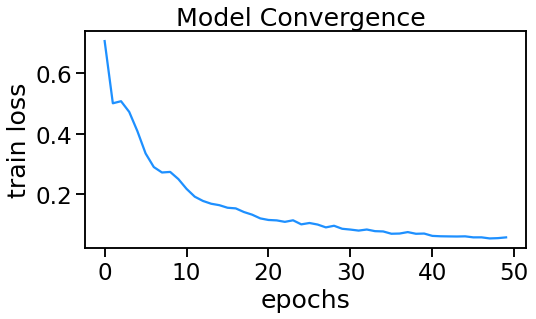

In [52]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr3)),train_loss_arr3,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

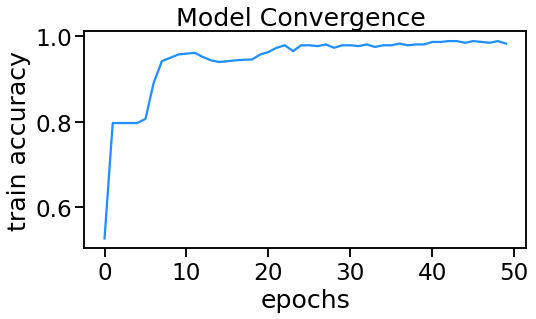

In [53]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr3)),train_acc_arr3,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

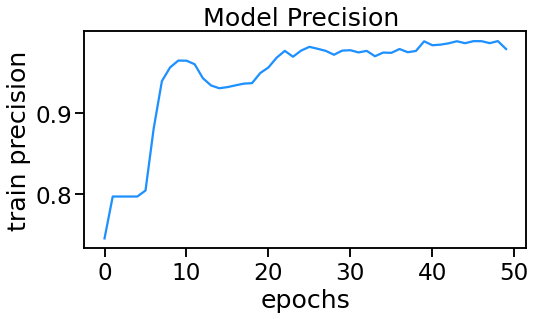

In [54]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr3)),train_prec_arr3,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

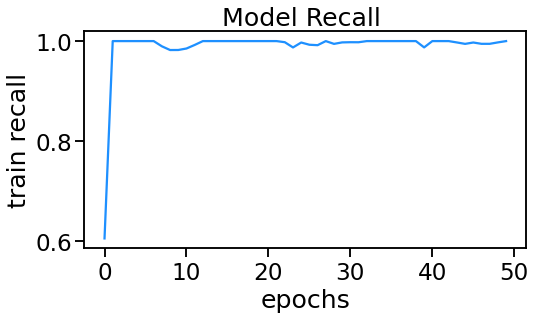

In [55]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr3)),train_recall_arr3,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

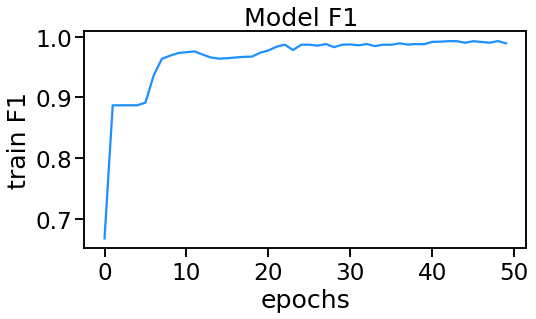

In [56]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr3)),train_f1_arr3,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [57]:
test_client_dataset1 = []
for i in range(len(test_dataset1)):
    test_client_dataset1.append((train_transforms(test_dataset1[i][0]), torch.Tensor([1,0]) if test_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))
test_client_loader1 = torch.utils.data.DataLoader(dataset=test_client_dataset1, batch_size=32)
len(test_client_loader1)

4

In [58]:
test_loss_arr3 = []
test_acc_arr3 = []
test_prec_arr3 = []
test_recall_arr3 = []
test_f1_arr3 = []

for batch_idx, (features, labels) in enumerate(test_client_loader1):
  local_loss, _tn, _fp, _fn, _tp = fl_server.train_test_model_and_get_loss(features,labels)
  _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
  _precision = _tp/(_tp+_fp)
  _recall = _tp/(_tp+_fn)
  _f1 = 2/((1/_recall) + (1/_precision))
  test_loss_arr3.append(local_loss)
  test_acc_arr3.append(_accuracy)
  test_prec_arr3.append(_precision)
  test_recall_arr3.append(_recall)
  test_f1_arr3.append(_f1)
  print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.07020921260118484 . Accuracy:  0.96875 . Precision:  0.9629629629629629 . Recall:  1.0 . F1-Score:  0.9811320754716982
Batch  1 . Loss:  0.02323106676340103 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0
Batch  2 . Loss:  0.12402153015136719 . Accuracy:  0.90625 . Precision:  0.9285714285714286 . Recall:  0.9629629629629629 . F1-Score:  0.9454545454545454
Batch  3 . Loss:  0.04028496518731117 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0


# **Averages**

In [59]:
import numpy as np

In [60]:
train_loss_arr_avg = np.mean(np.array([train_loss_arr1, train_loss_arr2, train_loss_arr3]), axis=0)
train_acc_arr_avg = np.mean(np.array([train_acc_arr1, train_acc_arr2, train_acc_arr3]), axis=0)
train_prec_arr_avg=np.mean(np.array([train_prec_arr1, train_prec_arr2, train_prec_arr3]), axis=0)
train_recall_arr_avg=np.mean(np.array([train_recall_arr1, train_recall_arr2, train_recall_arr3]), axis=0)
train_f1_arr_avg=np.mean(np.array([train_f1_arr1, train_f1_arr2, train_f1_arr3]), axis=0)

In [61]:
print(train_loss_arr_avg[-1])
print(train_acc_arr_avg[-1])
print(train_prec_arr_avg[-1])
print(train_recall_arr_avg[-1])
print(train_f1_arr_avg[-1])

0.053820274906077735
0.9867621527777778
0.9852757057826399
0.9983333333333334
0.9917514055367164


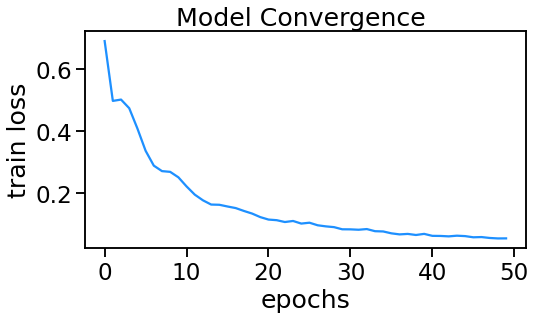

In [62]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr_avg)),train_loss_arr_avg,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

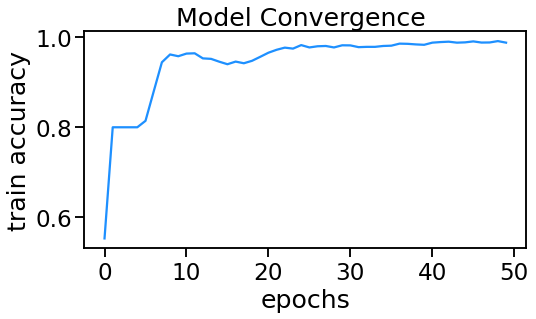

In [63]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr_avg)),train_acc_arr_avg,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

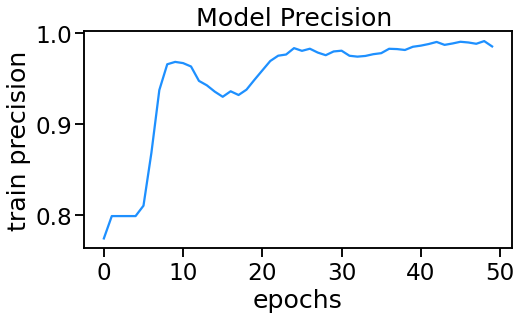

In [64]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr_avg)),train_prec_arr_avg,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

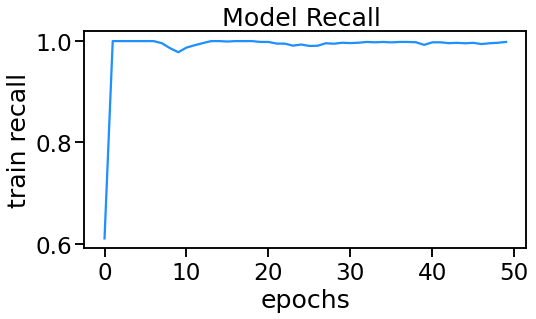

In [65]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr_avg)),train_recall_arr_avg,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

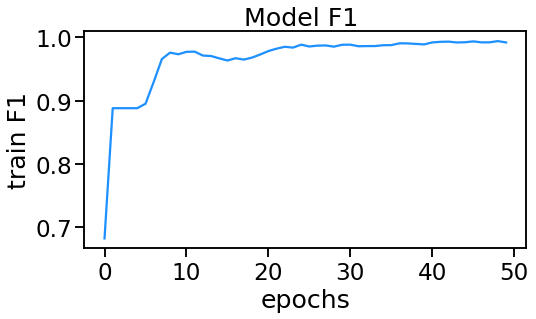

In [66]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr_avg)),train_f1_arr_avg,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [67]:
print("Batch 0", ". Loss: ", (test_loss_arr1[0]+test_loss_arr2[0]+test_loss_arr3[0])/3, ". Accuracy: ", (test_acc_arr1[0]+test_acc_arr2[0]+test_acc_arr3[0])/3, ". Precision: ", (test_prec_arr1[0]+test_prec_arr2[0]+test_prec_arr3[0])/3, ". Recall: ", (test_recall_arr1[0]+test_recall_arr2[0]+test_recall_arr3[0])/3, ". F1-Score: ",(test_f1_arr1[0]+test_f1_arr2[0]+test_f1_arr3[0])/3)
print("Batch 1", ". Loss: ", (test_loss_arr1[1]+test_loss_arr2[1]+test_loss_arr3[1])/3, ". Accuracy: ", (test_acc_arr1[1]+test_acc_arr2[1]+test_acc_arr3[1])/3, ". Precision: ", (test_prec_arr1[1]+test_prec_arr2[1]+test_prec_arr3[1])/3, ". Recall: ", (test_recall_arr1[1]+test_recall_arr2[1]+test_recall_arr3[1])/3, ". F1-Score: ",(test_f1_arr1[1]+test_f1_arr2[1]+test_f1_arr3[1])/3)
print("Batch 2", ". Loss: ", (test_loss_arr1[2]+test_loss_arr2[2]+test_loss_arr3[2])/3, ". Accuracy: ", (test_acc_arr1[2]+test_acc_arr2[2]+test_acc_arr3[2])/3, ". Precision: ", (test_prec_arr1[2]+test_prec_arr2[2]+test_prec_arr3[2])/3, ". Recall: ", (test_recall_arr1[2]+test_recall_arr2[2]+test_recall_arr3[2])/3, ". F1-Score: ",(test_f1_arr1[2]+test_f1_arr2[2]+test_f1_arr3[2])/3)
print("Batch 3", ". Loss: ", (test_loss_arr1[3]+test_loss_arr2[3]+test_loss_arr3[3])/3, ". Accuracy: ", (test_acc_arr1[3]+test_acc_arr2[3]+test_acc_arr3[3])/3, ". Precision: ", (test_prec_arr1[3]+test_prec_arr2[3]+test_prec_arr3[3])/3, ". Recall: ", (test_recall_arr1[3]+test_recall_arr2[3]+test_recall_arr3[3])/3, ". F1-Score: ",(test_f1_arr1[3]+test_f1_arr2[3]+test_f1_arr3[3])/3)

Batch 0 . Loss:  0.10327025999625523 . Accuracy:  0.9375 . Precision:  0.9272486772486772 . Recall:  1.0 . F1-Score:  0.9620222544750847
Batch 1 . Loss:  0.05610340336958567 . Accuracy:  0.9791666666666666 . Precision:  0.9743589743589745 . Recall:  1.0 . F1-Score:  0.9869281045751634
Batch 2 . Loss:  0.12917316953341165 . Accuracy:  0.9270833333333334 . Precision:  0.9302134646962233 . Recall:  0.9876543209876543 . F1-Score:  0.9580086580086579
Batch 3 . Loss:  0.03256028580168883 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0


In [68]:
print("Test", ". Loss: ", (test_loss_arr1[0]+test_loss_arr2[0]+test_loss_arr3[0]+test_loss_arr1[1]+test_loss_arr2[1]+test_loss_arr3[1]+test_loss_arr1[2]+test_loss_arr2[2]+test_loss_arr3[2]+test_loss_arr1[3]+test_loss_arr2[3]+test_loss_arr3[3])/12, ". Accuracy: ", (test_acc_arr1[0]+test_acc_arr2[0]+test_acc_arr3[0]+test_acc_arr1[1]+test_acc_arr2[1]+test_acc_arr3[1]+test_acc_arr1[2]+test_acc_arr2[2]+test_acc_arr3[2]+test_acc_arr1[3]+test_acc_arr2[3]+test_acc_arr3[3])/12, ". Precision: ", (test_prec_arr1[0]+test_prec_arr2[0]+test_prec_arr3[0]+test_prec_arr1[1]+test_prec_arr2[1]+test_prec_arr3[1]+test_prec_arr1[2]+test_prec_arr2[2]+test_prec_arr3[2]+test_prec_arr1[3]+test_prec_arr2[3]+test_prec_arr3[3])/12, ". Recall: ", (test_recall_arr1[0]+test_recall_arr2[0]+test_recall_arr3[0]+test_recall_arr1[1]+test_recall_arr2[1]+test_recall_arr3[1]+test_recall_arr1[2]+test_recall_arr2[2]+test_recall_arr3[2]+test_recall_arr1[3]+test_recall_arr2[3]+test_recall_arr3[3])/12, ". F1-Score: ",(test_f1_arr1[0]+test_f1_arr2[0]+test_f1_arr3[0]+test_f1_arr1[1]+test_f1_arr2[1]+test_f1_arr3[1]+test_f1_arr1[2]+test_f1_arr2[2]+test_f1_arr3[2]+test_f1_arr1[3]+test_f1_arr2[3]+test_f1_arr3[3])/12)


Test . Loss:  0.08027677967523535 . Accuracy:  0.9609375 . Precision:  0.9579552790759688 . Recall:  0.9969135802469137 . F1-Score:  0.9767397542647266


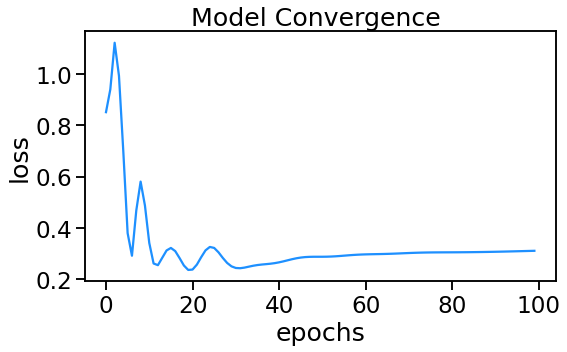

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr)),train_loss_arr,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

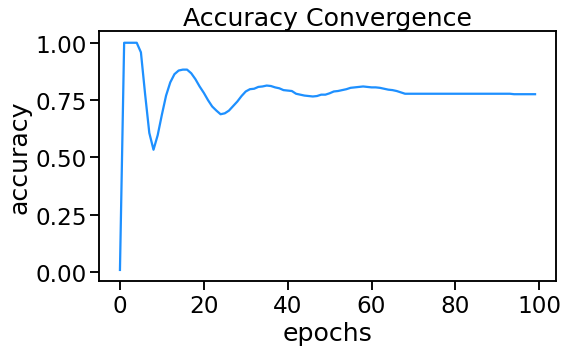

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr)),train_acc_arr,color='dodgerblue')
plt.title('Accuracy Convergence')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.tight_layout()

In [ ]:
# Only last layer trained
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 50
threshold = int(len(train_dataset) / 10)
train_loss_arr = []
train_acc_arr = []
train_prec_arr = []
train_recall_arr = []
train_f1_arr = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader))

clients_arr = []
for batch_idx, (train_features, train_labels) in enumerate(client_loader):
  clients_arr.append(FL_Client(train_features, train_labels))

for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0

  for fl_client in clients_arr:
    if epoch != 1:
      fl_client.set_weights(global_weights)
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy = (_tp+_fp)/(_tp+_fp+_tn+_fn)
    _precision = _tp/(_tp+_fp)
    _recall = _tp/(_tp+_fn)
    _f1 = 2/((1/_recall) + (1/_precision))
    local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2(local_gradients)
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr.append(loss)
  accuracy = (tp+fp)/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2/((1/recall) + (1/precision))
  train_acc_arr.append(accuracy)
  train_prec_arr.append(precision)
  train_recall_arr.append(recall)
  train_f1_arr.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  50
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.687995195388794 . L-AC:  0.4375 . L-P:  0.8571428571428571 . L-R:  0.5454545454545454 . L-F1:  0.6666666666666666
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.7281910181045532 . L-AC:  0.28125 . L-P:  0.7777777777777778 . L-R:  0.25925925925925924 . L-F1:  0.38888888888888895
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.6963469982147217 . L-AC:  0.3125 . L-P:  0.9 . L-R:  0.375 . L-F1:  0.5294117647058824
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.6958130598068237 . L-AC:  0.375 . L-P:  0.75 . L-R:  0.4090909090909091 . L-F1:  0.5294117647058824
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.7207984328269958 . L-AC:  0.375 . L-P:  0.75 . L-R:  0.36 . L-F1:  0.4864864864864865
Default client weights are used.
--------Epoch  

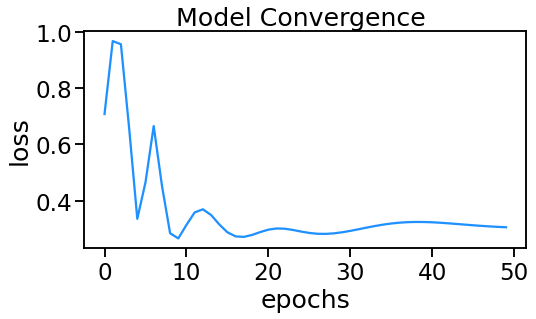

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr)),train_loss_arr,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

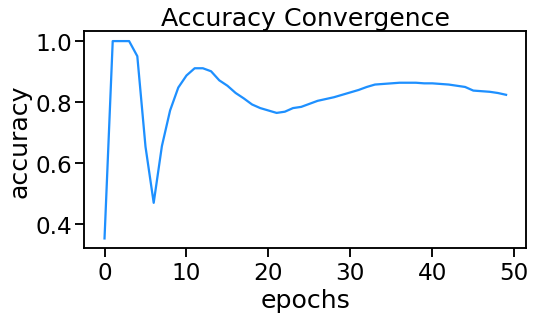

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr)),train_acc_arr,color='dodgerblue')
plt.title('Accuracy Convergence')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.tight_layout()

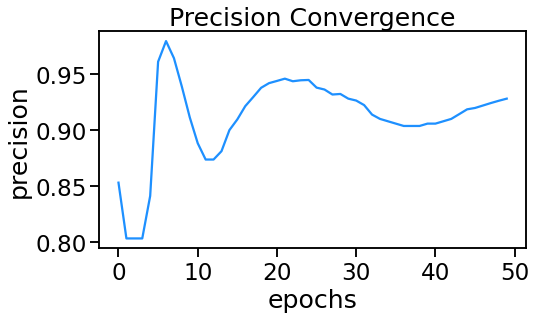

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr)),train_prec_arr,color='dodgerblue')
plt.title('Precision Convergence')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.tight_layout()

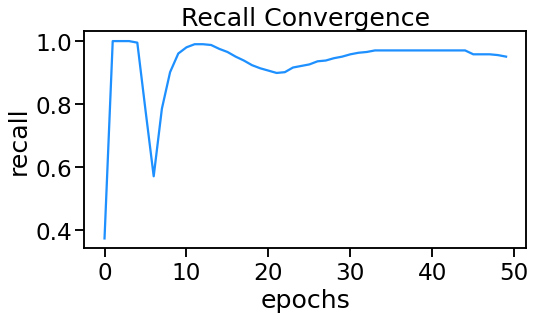

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr)),train_recall_arr,color='dodgerblue')
plt.title('Recall Convergence')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.tight_layout()

In [ ]:
# All layers trained
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 30
threshold = int(len(train_dataset) / 10)
train_loss_arr = []
train_acc_arr = []
train_prec_arr = []
train_recall_arr = []
train_f1_arr = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader))

clients_arr = []
for batch_idx, (train_features, train_labels) in enumerate(client_loader):
  clients_arr.append(FL_Client(train_features, train_labels))

for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0

  for fl_client in clients_arr:
    if epoch != 1:
      fl_client.set_weights(global_weights)
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy = (_tp+_fp)/(_tp+_fp+_tn+_fn)
    _precision = _tp/(_tp+_fp)
    _recall = _tp/(_tp+_fn)
    _f1 = 2/((1/_recall) + (1/_precision))
    local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2(local_gradients)
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr.append(loss)
  accuracy = (tp+fp)/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2/((1/recall) + (1/precision))
  train_acc_arr.append(accuracy)
  train_prec_arr.append(precision)
  train_recall_arr.append(recall)
  train_f1_arr.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  30
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.6485392451286316 . L-AC:  0.9375 . L-P:  0.8 . L-R:  0.9230769230769231 . L-F1:  0.8571428571428572
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.628125011920929 . L-AC:  0.90625 . L-P:  0.8275862068965517 . L-R:  0.8888888888888888 . L-F1:  0.8571428571428572
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.6194213032722473 . L-AC:  0.875 . L-P:  0.8214285714285714 . L-R:  0.8846153846153846 . L-F1:  0.8518518518518517
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.6313815116882324 . L-AC:  0.8125 . L-P:  0.8076923076923077 . L-R:  0.8076923076923077 . L-F1:  0.8076923076923077
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.642758846282959 . L-AC:  0.71875 . L-P:  0.8260869565217391 . L-R:  0.7307692307692307 . L-F1:  0.77551020408

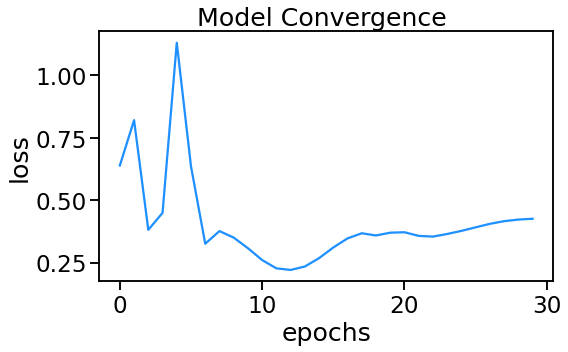

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr)),train_loss_arr,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

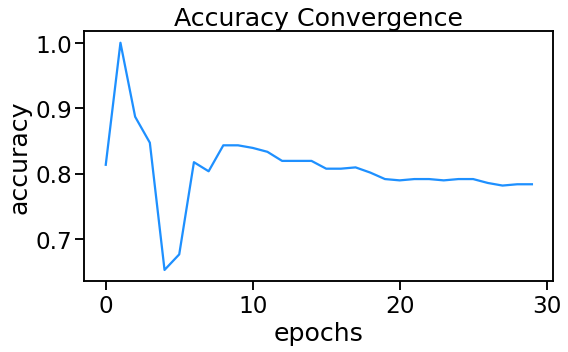

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr)),train_acc_arr,color='dodgerblue')
plt.title('Accuracy Convergence')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.tight_layout()

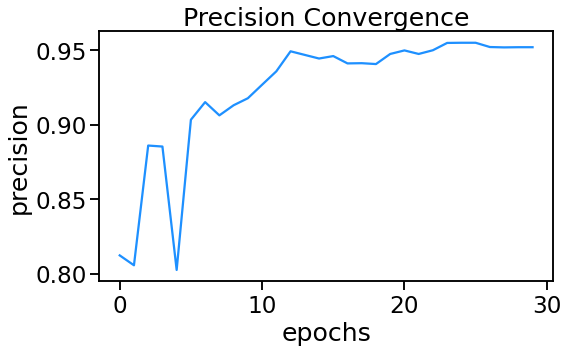

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr)),train_prec_arr,color='dodgerblue')
plt.title('Precision Convergence')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.tight_layout()

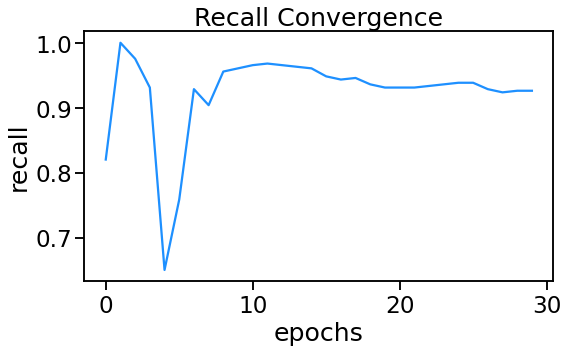

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr)),train_recall_arr,color='dodgerblue')
plt.title('Recall Convergence')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.tight_layout()

In [ ]:
w# as you can see current ram is 12GB only, to increase it run below code

In [ ]:
i = []
while True:
  i.append(i)

In [ ]:
# wait for few minutes, after that you will get a prompt that your notebook got crashed, do you want to increase ram ?

In [ ]:
# in the prompt click - yes

In [ ]:
# as you see the ram increase from 12GB to 25GB

In [ ]:
#thanks for watching, keep learning 

**NOTE**: PLease allow your browser to allow show pop-ups by sites as show below 

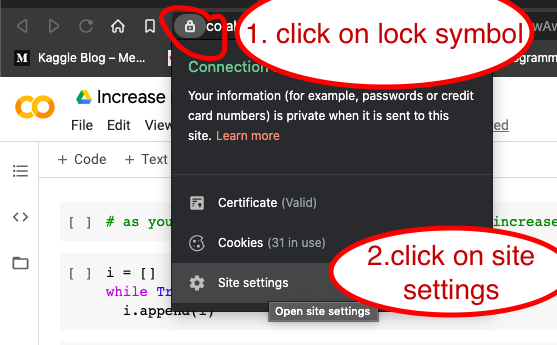

In [ ]:
#step-1

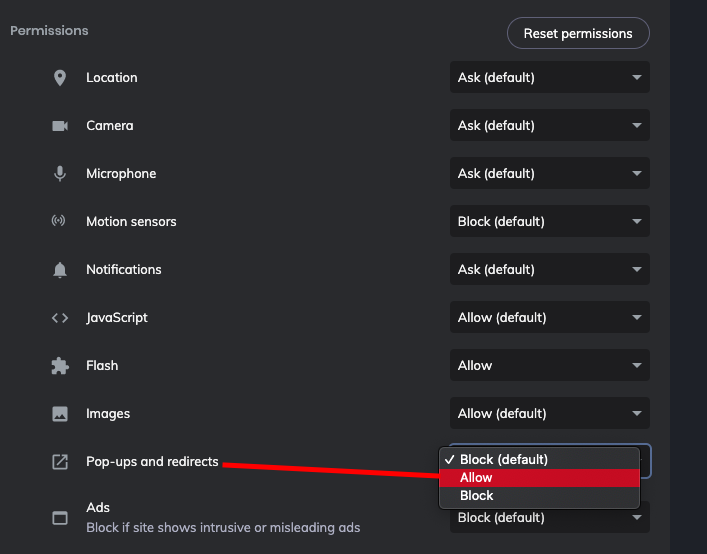

In [ ]:
#step-2